# SWE Forecasting with Machine Learing (ML)
In this lab we will develop a machine learning model to predict snow water equivalent in the mountains. This labs takes datasets we have looked at in various ways in  prior labs and integrates thouse findings in to a machine learning model that can preict SWE in the mountains of Afganistan. 

#### Machine learning modls are statistical methods that take ***predictors*** as inputs and generate a ***target*** output. 

The ML model we are going to predict SWE with is called **Random Forest**. We will be developeing a model that predicts SWE for ~10km2 areas of the Panjashir Basin in Afganistan. In our model, we are going to use a mix of static charateristics about each location, like elevation, and dynamic charatieristics like snow covered area. All of the predictors are avalible in near real time during the snow season. To train and validate our model, since we do not have spatially distributed in situ mesurements of SWE, we will be using reconstucted SWE, the SWE produt we explored in Lab 3, which is the clsest ground truth avalible for data-sparse regions with minimal cloud cover durring the melt season. 


## Lab Outline
- Learn how to train, run, and anlyize a Random Forest machine learning model with a pratice dataset.
- Understand the set up of a Machine Learning model for SWE prediciton.
- Train a SWE machine learning model
- Run a SWE machine learning model
- Vizualize machine learning model output
- Use the SWE machine learning model to make SWE predictions for various water years
- Compare the SWE machine learning model predictions to alternative methods from Lab 1 and Lab 3

This lab uses the methods developed and published here: https://doi.org/10.5194/tc-12-1579-2018


# Part 1: Picking the right model. 

## Machine Learning Overview - Classification vs Regression
In general there are two main types of machine learning models. They are differenitead based on the type of output they produce. 
- ***Classificaiton*** models catagorize outputs. Classificaiton models predict a catagorical class based on the predictor data. 
- ***Regression*** models return continous output. Regression models predict an answer along a continous range of values. 

Many apporaches to machine learning, can be tweaked to model data in either of these two ways. The first important step in setting up an ML model is to ask yoursuelf: 
#### ***What is the output I want from my model? Is it catagorical or continous?***


## GROUP QUESTIONS: 
### ***For our SWE ML model what is our output variable, the "target" of the model?***

### ***What type of ML model do we want, a Classificaiton or a Regression model?***

Snow water equivalent is our target variable. SWE is a continous variable. We want to use a regression model. SWE values can range continously from zero millimeters to upwards of  hundreds of millimeters.  This is the most importnat point when looking into finding a solution that can predict SWE - knowning that we are interested in a regression model that outputs a continous variable lets us focus in on this specific type of machine learning model to find a solution. 


## Random Forest Models

Random forst models can be set up to perfrom classificaiton or regression. We will be using the scikit-learn in python to implement a regression random forest ML algorithm to predict SWE. Below are references to documentaion on the scikit-learn emplementaiton we will use:
- scikit-learn overview: https://scikit-learn.org/stable/index.html
- random forest implementation: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor
- scikit-learn "make regression" function, great for learning how algorithms work: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html 


Random forest models are based on decision trees. https://en.wikipedia.org/wiki/Decision_tree

Instead of making one decison tree for our prediciton, a Random Forest algorithm make many decision trees that are all slightly different. With an esmeble of trees, our prediction is the average of all preditions across the trees that we have trained with our training set. 

***the main insight behind Random Forests performing better than any single decion tree is that the average answer of all the deision trees is going to be a better prediction than predictions from any single decision tree.***


## Growing the Random Forest: Bagging and Bootstrapping

How do we create these replicated trees? How do we make sure that they are different yet represenative of our dataset so that we can leverage results of all the trees into one prediciton?

We use a technique called ***Bagging***
Bagging is a technique where we create a large number of trees by taking "bootstapped" samples from our dataset. 
a ***Bootstrapped*** sample is sampling with replacement. Each randomized subset of data that we extract is picked from the full dataset. ***This means that individual measurements can be in multiple trees, but no two trees will be the same.***

Becuase each tree will be unique, they will all produce slightly different answers. think of each indivual decision tree that we created by taking a bagged sample from the main dataset as its own stand alone descions tree. What we are going to do is use the main assumption of this method which is that ***The averaged output of all the ensemble trees is a better answer than any one individual trees prediciton***. But at the core of the algorihtm, each bagged tree is a simple decision tree in the middle of a large **"Random Forest"**. We created a ***"forest"*** of decison trees with a randomzed method. 

The last detail about the random forest, is that in addition to randomly selecting datapoints to be used to create each tree, each split in the tree is generated with a random subset of predictors. So ***each tree is grown from a different subset of predictiors and trained on a differnet subset of data from our dataset.*** 

# PART 1: Creating a Random Forest algorithm on example data
Before we use SWE data, lets explore how the algorthm works, and ways to evalute performance with a smaller and simpler implementation. We can use the make_regression function in scikit-learn to generate a dataset of predictors and outcomes that have a known relationship, with some noise thrown in. This lets us explore how the model works, how we can understand how well it performs, and things we can modify to try an increase preformance. 

## Set up the Lab workspace

In [1]:
#everything we need for the lab
import sklearn
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import log as ln
from joblib import load
import geopandas as gpd 
from shapely.geometry import Point
from shapely.geometry import Polygon
import contextily as ctx

## Create an example dataset to practice with
The funciton below is a easy way to quickly create an example dataset. Data that is in the correct format and ready to use to try running machine learning models. The **make_regression** function creates a dataset **"X"** which predicts **"Y"**. 
we have set it up to generate a dataset with 2000 samples with 15 features and 7 of the features are useful for predicting Y. 
- This is important. Commong to many machine learning problems is that sometimes featueres you have chosen are not that great at generateing predicitons. You want to know if you can identify which predictors are poor, or if the model still preforms well even if some of the input data is of low quality.

Y is a scalar output i.e. one continous value, we have added some noise to the dataset and set "random_state" which means that each time we call this funciton, the results are reproducable. To see why this matters, try running
this section of code with the example test data without the random_state paraemter set, and see what happend to your answers each time the code is run! 

In [2]:
#lets generate a test case to learn about how the random forest machine learning algorihtm works
#X = the set of predictors, variables that we use to predit our outcome
#Y = the outcome, the value we want to predict with our model. 


# create the dataset
X,Y=make_regression(n_samples=2001,n_features=15,n_informative=7,n_targets=1,noise=0.15,random_state=1)

## Visualize predictor similarity with correlation plot 
A good way to look at how useful predictor variables might be is to use a correlation plot. 

Correlation between predictors and targets is desirable
but correlation between predictors, called collinearity, is not.
Collinearity does not degrade the performance of the models,
but makes assessment of the importance of the correlated predictors
independently more difficult

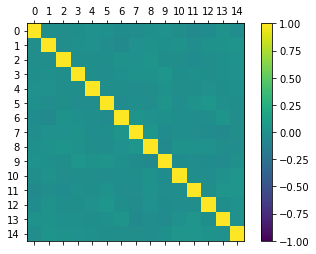

In [3]:
data=pd.DataFrame(X)
correlations = data.corr()
# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,15,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
plt.show()

## Train the Random Forest model
The scikit-learn function **RandomForestRegressor** is how we generate a random forest regressor model. Since our dataset we made has 2000 datapoints, we can use the first 1999 datapoints to train the model and then see how well it does predicting the 2000th datapoint.

In [4]:
#we want to train a random forest regressor to predict Y from X
model=RandomForestRegressor()

#fit the model with the first 2000 datapoint in our dataset
trainX=X[0:1999,:]
trainY=Y[0:1999]
model.fit(trainX, trainY)

RandomForestRegressor()

## Make a prediction with the Random Forest model

In [5]:
#predict the outcome Y on the last datapoint
testX=X[2000,:]
testX=testX.reshape(1,-1)

#lets keep track of the value we are trying to predict with the model, we can compare this "truth" value
#to the model output.
truthY=Y[2000]

#lets run the trained ML model and try and predict Y
predictY=model.predict(testX)
print('Prediction: ' + str(predictY[0]) + ' Truth: ' + str(truthY))

Prediction: 140.32435179227534 Truth: 147.96294682888842


## Visualize predictor feature importance
one nice aspect of random forest models is that we can visualize how important each feature was at making the final predictions. This is a good way to help understand which of your predictors are most helpful at arriving at useful predicitons. You can use this information to try various preditors and priotitize which datasets you want ot be usre to include in future models. 

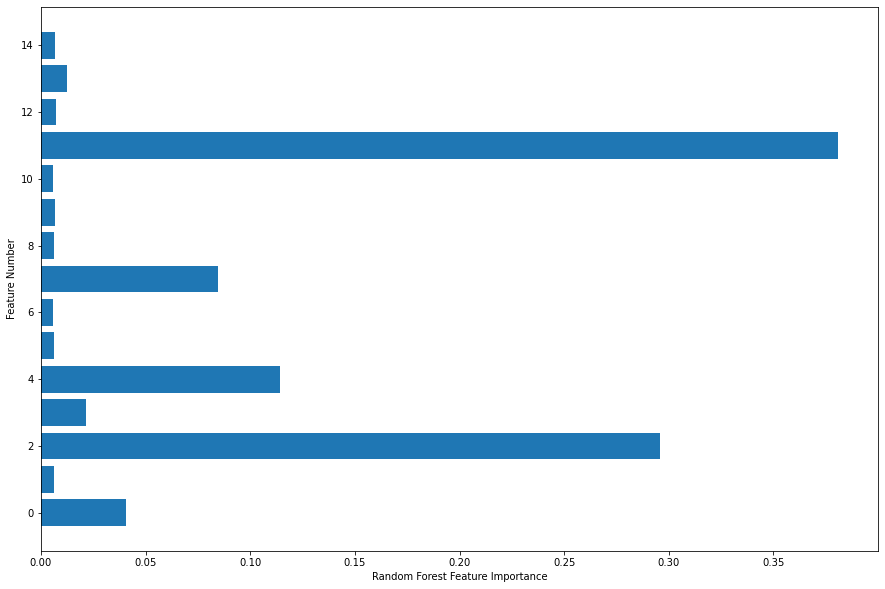

In [6]:
#calculate and plot feature importance
sorted_idx = model.feature_importances_.argsort()

#define plot space
fig, ax = plt.subplots(figsize=(15,10))

#plot each features importance as a bar chart
plt.barh(data.columns.values[sorted_idx], model.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.ylabel("Feature Number")
plt.show()

Now that we have used a random forest algorithm and explored how it can be used to predict outcomes and evaluate its performance, lets now use these methods to predict the snow water equivalent in the panjasher basin in afganistan. 

# PART 2: SWE ML in Panjasher Basin of Afganistan

## Predictors and Targets
A mix of static physiographic and dynamic variables are used. 
The time period each year the model is run is april-june and the years are 2003-2011
The spatial resolution of the model is 3.125x3.125km.
All of the variables below have been assembled into tables that are ready to be input into our Random Forest ML models. 

### Physiographic Predictors:
| Name | Description|
|-------|------|
| Day of Year | we use the sine of the day of year, this enables us to model day of year as a continous variable |
| Elevation | Pixel average elevation |
| Latitude | Pixel center latitude |
| Longitude | Pixel center longitude |
| Northwest/west/southwest barrier difference "shield height" | Elevation difference between pixel and highest pixel in each direction |
| West/southwest distance to ocean | Pixel distance to ocean or sea in each direction |
| Southness | Computed as sin(slope) X cos(aspect), with slope as upward from horizontal and spects from south with counter-clockwise as positive |

### Dynamic Predictors:
| Name | Description|
|-------|------|
|TB<sub>10V</sub>-TB<sub>18V</sub>| Difference between ehnahced resolution PM brightnes temperature at 10GHz, vertically polarized, and 18 GHz, vertically polarized |
|TB<sub>18V</sub>-TB<sub>36V</sub>| Difference between ehnahced resolution PM brightnes temperature at 18GHz, vertically polarized, and 36 GHz, vertically polarized |
| F<sub>sca</sub> | Fractional snow-coverewd area |
| Mean reconstructed SWE | Mean daily SWE computted over all years except the target year |

### Target:
| Name | Description|
|-------|------|
| Reconstructed SWE | Reconstructed daily SWE |


***Passive Microwave info:***
Only nighttime data from the microwave brightness temperatures is used. The snowpack is usually frozen at night and passive microwave data cannot retieve SWE from wet snow. The 36 GHzV (vertical polarization) brightness temperatures are available at 3.125 km, but the 18 GHzV brightness temperatures are available only at a resolution of 6.25 km, so the 18 GHz brightness temperatures were resampled to the 3.125 km resolution. Likewise, the 10 GHz brightness temperatures are available only at 12.5 km resolution, so they were also resampled to 3.125 km. Two different brightness temperature differences (T<sub>18V</sub>–T<sub>36V</sub> and T<sub>10V</sub>–T<sub>18V</sub>) are used to account for shallow and deep snow.

As we learned in Lab 1, the passive mirowave data is not collected each day - there are gaps between swaths of satellite data at the latitude of afganistan. We fill these gaps by using bilinear interpolation and then smoothed using a 7-day moving median filter.

## Pick a year to predict SWE for:
We will start by trying to predict the daily SWE in the Panjasher basin durring the melt season of 2011.

In [7]:
testYear=2011

## Generate training data

For  model training, we will try and predict SWE from each year of our dataset by using the other years of data as training data. First, we will try and predict 2011 SWE by selecting 80,000 training observations from 2003-2010 to train the model on. Then, with the trained model, we will use the predictors from 2011 to try and predict the target year SWE. 

In [8]:
# create a sample of 80,000 observations to train the model on. 
# We want these observations to be sampled from all of our data we have from 2003-2010

file_name = '{}Table.csv'
# create the table of samples sfrom 2003-2010
# fyi - range function does not include the stop number (2011)
k=1
for i in range(2003, 2012):
    
    #dont sample from the year we are predicting
    if i==testYear:
        continue
        
    print(i)
    #read in the years data
    tmpTbl=pd.read_csv(file_name.format(i))
    
    # delete pixels without fsca and outside of the basin
    tmpTbl = tmpTbl[(tmpTbl.fsca != 0) & (tmpTbl.mask != 0)]

    # sample 10,000 observations from this year
    tmpTbl=tmpTbl.sample(n=10000,random_state=1)
    
    #create a new training table of the sampled values from each year
    if k==1:
        trainTbl=tmpTbl
    else:       
        trainTbl=pd.concat([trainTbl, tmpTbl])
    k=k+1

trainTbl.shape

2003
2004
2005
2006
2007
2008
2009
2010


(80000, 10)

The output above shows that we created a table with 80,000 rows of observations and 18 features. Lets look at the data in the table, these are a mix of features for each pixel that might help us predict the SWE

In [9]:
trainTbl.head(100)

,doy,doy_sin,Elevation_m,Latitude,Longitude,fsca,recon_swemean,recon_swe,TB10V_TB18V,TB18V_TB36V
27410,161,98,3234,3520,6977,3,0,6,7.584442,7.452179
22315,148,96,3327,3571,7014,28,0,28,3.527710,12.080890
12196,122,87,3288,3520,6959,41,0,53,4.461700,21.035340
30107,168,99,4486,3554,7006,39,0,102,3.932373,14.748310
21913,147,95,3119,3545,6988,22,0,16,1.811432,5.854156
...,...,...,...,...,...,...,...,...,...,...
16699,134,91,3860,3568,6980,86,217,260,6.293167,35.863300
25939,158,98,4185,3540,6938,61,282,323,6.658081,33.298170
18368,138,93,4080,3576,7008,84,259,278,9.858582,42.592030
7908,111,82,2764,3540,6973,11,63,8,0.150284,0.471832


## Create target variable 
Our measure of SWE, that we are using at the truth for our model training is reconstucted SWE. we will pull that variable out of our table and set it as **Y** our **Target Output**

In [10]:
Y=trainTbl.recon_swe

## Create our predictor features DataFrame
Now that we have seen the data, we need to clean it up a bit. First, we do not want our output in the predictor table anymore. We need to remove reconstructed SWE from the table. We also do not want to predict SWE for pixels with 0 fsca, as we already know the answer (0 SWE). The model would be able to easily predict the output for these rows, and give us a false since of accuracy of our model. We only want to train and test the model on rows where we have fractional snow cover. Afganisatn does not have much canopy cover - most of the pixels with canopy cover range from 1-2% vegitative cover, so we will remove this varibale as well. We also have a dupliate of DOY (day of year) and doy_sin. doy_sin is a continous variable for doy that we want to use instead of the actual date, so we will delete to doy variable. The mask variable is 1 for all pixel that are wihtin the basin. Since every row of our predictor table is within the basin, we can delete this varibale and not use it for predictions. Generally, if you have a feature that is exactly the same for evey observation, it will not be useful to include in a ML model. 

In [11]:
# just delete the traget variable, we want to use all the predicitos
###trainTbl=trainTbl.drop(columns=['recon_swe','doy','cc','mask']) 
###trainTbl.head(50)

#TEST - JUST USE THE FEATURES THAT ARE PREDICTIVE
trainTbl = trainTbl[['doy_sin', 'Elevation_m', 'fsca','TB10V_TB18V','TB18V_TB36V','recon_swemean']].copy()
trainTbl.head()

,doy_sin,Elevation_m,fsca,TB10V_TB18V,TB18V_TB36V,recon_swemean
27410,98,3234,3,7.584442,7.452179,0
22315,96,3327,28,3.527710,12.080890,0
12196,87,3288,41,4.461700,21.035340,0
30107,99,4486,39,3.932373,14.748310,0
21913,95,3119,22,1.811432,5.854156,0


In [12]:
trainTbl.shape

(80000, 6)

From the output above we can see that we now have a table with 80,0000 observations at 6 features for each observation. This is the final set of data we want to use to train our model. 

A good thing to always check it to make sure that all the input data is valid. Sometimes models can handle missing values, sometimes they cannot. The random forest algo cannot handel missing values, so we need ot check and make sure that no rows have any missing data

In [13]:
trainTbl.dropna() 
trainTbl.shape

(80000, 6)

After running the code to drop any rows that have missing data for any features we can see that our dataset did not change size, we still have 80,000 rows. This is good. This means that all of our 80,000 observations have data for each of the 14 features that we will use to predict SWE.

## Visualize Predictors with correlation plot

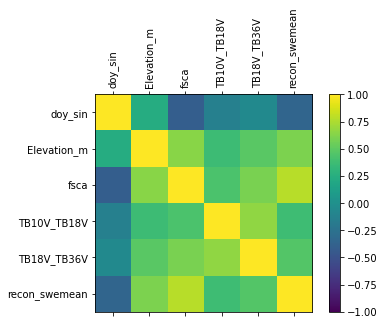

In [14]:
correlations = trainTbl.corr()
# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,6,1)
###ticks = np.arange(0,14,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(trainTbl.columns.values,rotation = 90)
ax.set_yticklabels(trainTbl.columns.values)
plt.show()

## Train the SWE ML model

ADD TEXT HERE. Training can take some time. Be patient..... It can take 10-15 minutes.  

Take this time to go back to the top part of the lab and think about what is going on in the model training.....

The model is using all 80,0000 observations and 14 features to randomly select subsets of the 80,000 observations and randomly select subsets of the 14 features to create many decisions trees and train each decision tree on the subset of the data is was grown with. It is then putting all the trees togeather into one model that can pass input data into all the trees and average all the tress outputs into one answer that will be returend to use from the trained model. 


ADD SAVED TRAINED MODELS FOR EACH COMBINCATION OF YEARS....


Generally you want a large number of "trees" in your "random forest" each tree that is added to the forest increases the size of the saved ML model. The default in scikit-learn is to build a model with 100 trees. For our dataset, that creates  models that are ~500MB uncompressed and ~100MB compressed. Inreasing the number of trees can improve the model and decreasing the number of trees can improve the seppd of the model and make it more portable. To experiment in this lab, we will be using small random forests of 10 trees each to reduce the size of our image. 

In [15]:
#put in format for bagged algo
#we want to train a random forest regressor to predict Y from X
SWEmodel=RandomForestRegressor(n_estimators=5) #default it 100 (too large for Binder Image)

#train the model on the dataset
SWEmodel.fit(trainTbl, Y)

RandomForestRegressor(n_estimators=5)

## Load in test year data to predict SWE 

In [16]:
#  we will try and predict the SWE for this year based on out model trained with data from the other years.
sweTbl=pd.read_csv(str(testYear)+"Table.csv")
# delete pixels without fsca and outside of the basin
sweTbl = sweTbl[(sweTbl.fsca != 0) & (sweTbl.mask != 0)]

#testing data to validaitate the model
truthSWE=sweTbl.recon_swe

#location of each location we train the model for mapping later
lat=sweTbl['Latitude']/100
lon=sweTbl['Longitude']/100

#predictors of SWE that go into the model - same as 2003-2010 data
doy=sweTbl.doy # we need this later
###sweTbl=sweTbl.drop(columns=['recon_swe','doy','cc','mask']) 
sweTbl = sweTbl[['doy_sin', 'Elevation_m', 'fsca','TB10V_TB18V','TB18V_TB36V','recon_swemean']].copy()
sweTbl.head()

,doy_sin,Elevation_m,fsca,TB10V_TB18V,TB18V_TB36V,recon_swemean
0,71,4229,88,8.050858,11.91092,504
1,71,4045,86,8.319595,11.86450,503
2,71,4261,93,8.864441,16.72073,518
3,71,3933,86,8.375107,24.54617,415
4,71,4215,90,7.231659,12.77991,476


## Run the Random Forest Model to make SWE predictions

In [17]:
#lets run the trained ML model and try and predict SWE
predictSWE=SWEmodel.predict(sweTbl)

## Visualize SWE predictions

<AxesSubplot:xlabel='lon', ylabel='lat'>

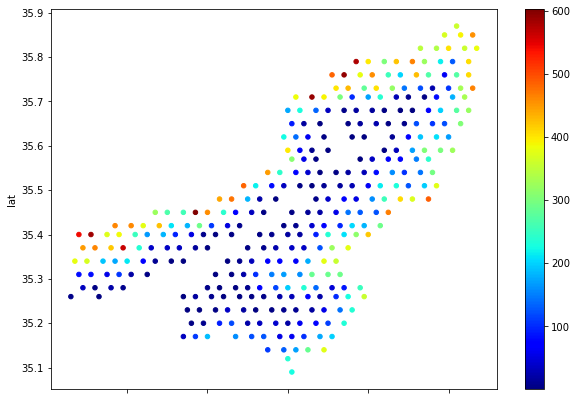

In [18]:
# lets vizualize our SWE prediction,
# first lets take our output and the lat/lon locations and
#turn into a dataframe for easy plotting
SWE=pd.DataFrame(data={'doy':doy,'lat':lat,'lon':lon,'SWE':predictSWE})
plotSWE=SWE[SWE.doy==130]
plotSWE.plot(kind="scatter", x="lon", y="lat",
                      c=plotSWE['SWE'],cmap=plt.get_cmap('jet'),
                      colorbar=True, figsize=(10,7))

The above graphic is Okay, but we want to see the SWE estimates in the local context. the output above has not geogrpahic information associated with the plot - we jsut used longitude and latitude as X and Y coordiantes. NExt, we will add geographic infomraiton to our datframe and then flow th answers over a basemap. 

## Plot SWE predicitons on a Basemap

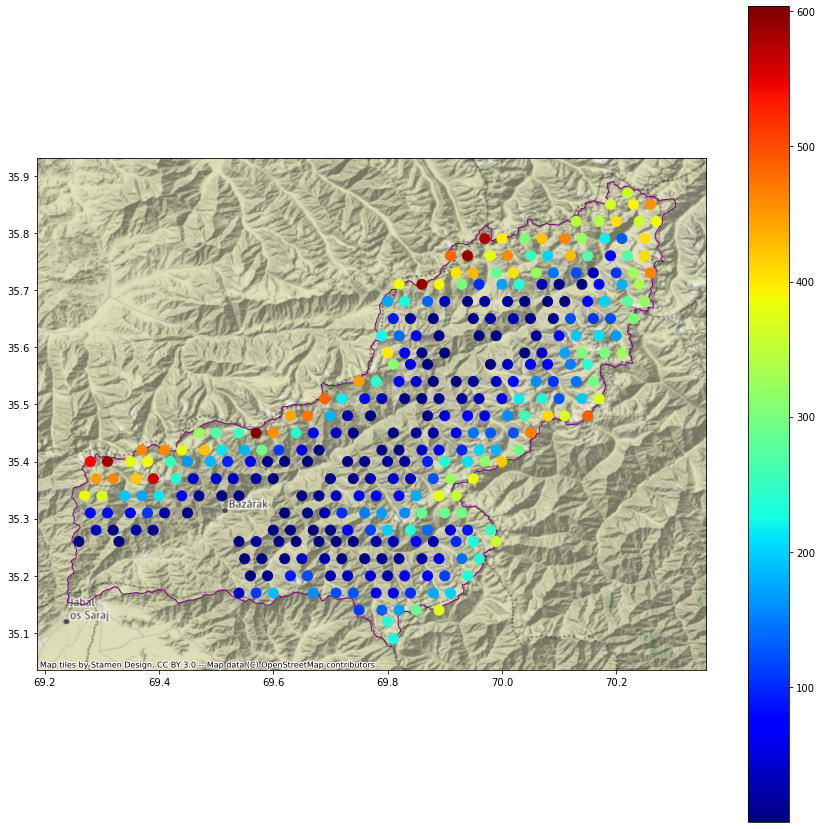

In [19]:
#shapefile boundary of our AOI
aoiFile='panjsher_basin_afghanistan_wgs84.shp'
#load
AOI = gpd.read_file(aoiFile)
AOI.crs= "EPSG:4326"

#convert the dataframe with our marchine learing output into a geodataframe
geometry = [Point(xy) for xy in zip(plotSWE.lon, plotSWE.lat)]
geoSWE = plotSWE.drop(['lon', 'lat'], axis=1)
geoSWE = gpd.GeoDataFrame(geoSWE, crs="EPSG:4326", geometry=geometry)

#plot
fig,ax=plt.subplots(figsize=(15,15))

#basin boundary in purple
ax = AOI.plot(ax=ax, edgecolor="purple", facecolor="None", zorder=1)

#SWE data with colorbar
ax = geoSWE.plot(ax=ax, column='SWE', markersize=100, cmap='jet', legend=True, zorder=2)

#basemap
ctx.add_basemap(ax, crs="EPSG:4326"); 

## Calculate basin wide SWE depletion prediction curve

These data as in Labs 1 and 3 are in an equal area projection, so it is easy to see the basin wide SWE each day. Lets calculate the estimate of the total SWE in the basin on a single day. TO do this we need to get the area of the basin, we can then use this equaiton to estiamte the total columne of water stored as seasonal snow in the basin. The panjashir basin is 4373 square kilomters. Our pixel size for the Machine Learning model is 3.125x3.125km pixels, so each pixel is 9.7656 square kilometers.

pixelsize (km2) * depth of SWE (km) =sum for all pixels


In [20]:
#calculate volume in each pixel
#convert mm to km and then multiply depth (in km) by area (in km2) to get vol (km3)
SWE['pxlVol']=SWE['SWE']*1e-6*3.125*3.125


## Visualize basin wide SWE depletion prediction curve

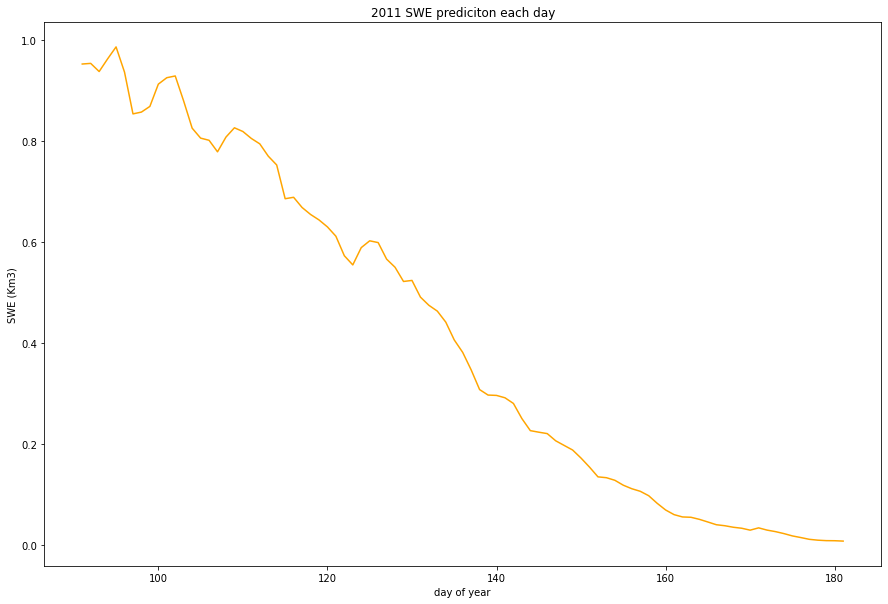

In [21]:
#now that we have a column that is the volume in cubic kilometers of each pixel, we can sum by day to see
#our estimate of the daily water sotrage in the basin.

#define plot space
fig, ax = plt.subplots(figsize=(15,10))

#define x and y axis data
SWE.groupby('doy')['pxlVol'].sum().plot(kind='line',x='day of year',y='SWE (mm)',color='orange', ax=ax)

#set plot title and axes labels
ax.set(title=str(testYear)+' SWE prediciton each day',
       xlabel='day of year',
       ylabel='SWE (Km3)')

plt.show()


# PART 3: Compare ML SWE Predictions to other methods

In the other labs we have explored other ways to estimate SWE in the Panjasher Basin. Lets now compare each method to each other method and see how the SWE ML answers compare. 

First, one way we can visually look at how our machine learning estimate does each day is to compare it to the reconstructed SWE estimate that we have for the basin - the variable we trained the model to predit. Since we are using historical data in the lab, we have the reconstruction data avalible for any year we choose to try and predict the SWE. We can plot reconstructed SWE alongside the machine learning prediciton to compare the two. 

In [22]:
SWE['truthSWEpxlVol']=truthSWE*1e-6*3.125*3.125

## Plot ML SWE and Reconstructed SWE

In the table above you can see that we have two columns now, 'pxlVol' is the machine learning predition for the volume of water in the 3.125km by 3.125km pixel and then 'truthSWEpxlVol' is our 'truth' measurement, the reconstructed SWE that we can calculate after the fact using the energy balance method from Lab 2.  As a first comparison, lets plot against each other for the whole basin. 

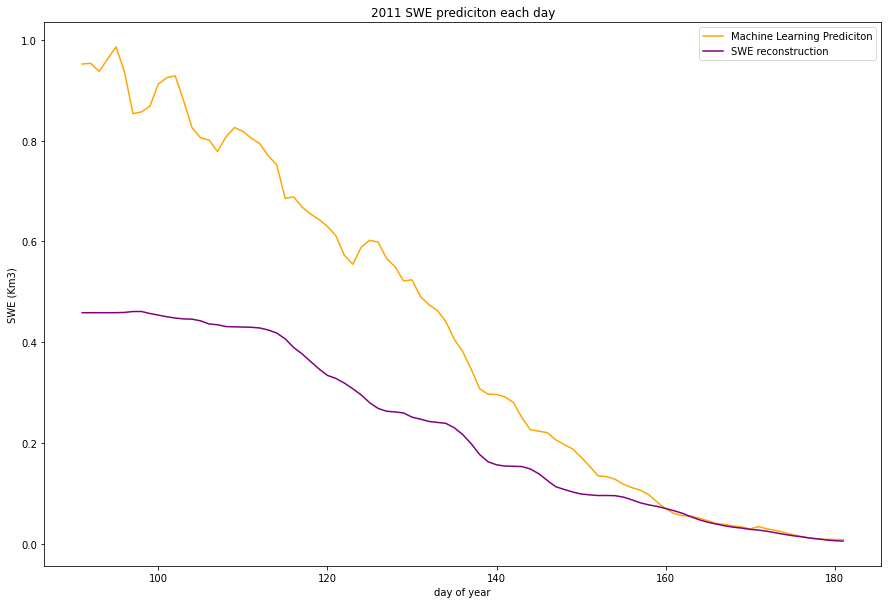

In [23]:
#define plot space
fig, ax = plt.subplots(figsize=(15,10))

#define x and y axis data - Machine Learning Prediction
SWE.groupby('doy')['pxlVol'].sum().plot(kind='line',
                                        x='day of year',y='SWE (mm)',
                                        color='orange', label= 'Machine Learning Prediciton', ax=ax)

#define x and y axis data - Truth data from SWE reconstruciton
SWE.groupby('doy')['truthSWEpxlVol'].sum().plot(kind='line',
                                        x='day of year',y='SWE (mm)',
                                        color='purple', label = 'SWE reconstruction', ax=ax)

#set plot title and axes labels
ax.set(title=str(testYear)+' SWE prediciton each day',
       xlabel='day of year',
       ylabel='SWE (Km3)')

#plot all the data
plt.legend(loc='best')
plt.show()

We can see that the machine learning prediction is just okay. lets dive in now and see how our different predictors helped us predict SWE and see if we can gain any insight into why our predciton is off. 

## Plot ML SWE, Reconstruction SWE, AMSR SWE, and ERA-5 SWE

In [24]:
#load the PM and AMSRSWE basin predicitons and plot as well. - Need to have these data cleaned and imported. 
file_name = '{}BasinSWE_km3_AMSR_ERA5.csv'
opSWE=pd.read_csv(file_name.format(testYear))
opSWE.head()

,doy,basinSWE_amsr,basinSWE_era5
0,91,0.5139,2.2500
1,92,-99.0000,2.2644
2,93,0.5733,2.2509
3,94,-99.0000,2.2779
4,95,0.6615,2.3022


Above is the operational SWE products for this basin. Why are there -99 values on some days for the AMSR swe product? 
hint ( think about lab 1 and what we learned about passive microwave measurements) 

In [25]:
#-99 are fill values for days we dont have passive microwave measurements.
opSWE.loc[opSWE['basinSWE_amsr']==-99,'basinSWE_amsr']=np.nan
opSWE.head()

,doy,basinSWE_amsr,basinSWE_era5
0,91,0.5139,2.2500
1,92,NaN,2.2644
2,93,0.5733,2.2509
3,94,NaN,2.2779
4,95,0.6615,2.3022


now lets plot the reconstructed swe, the ERA 5 swe estimate, the AMSR SWE estimate for the basin and the Machine learning SWE estimate.

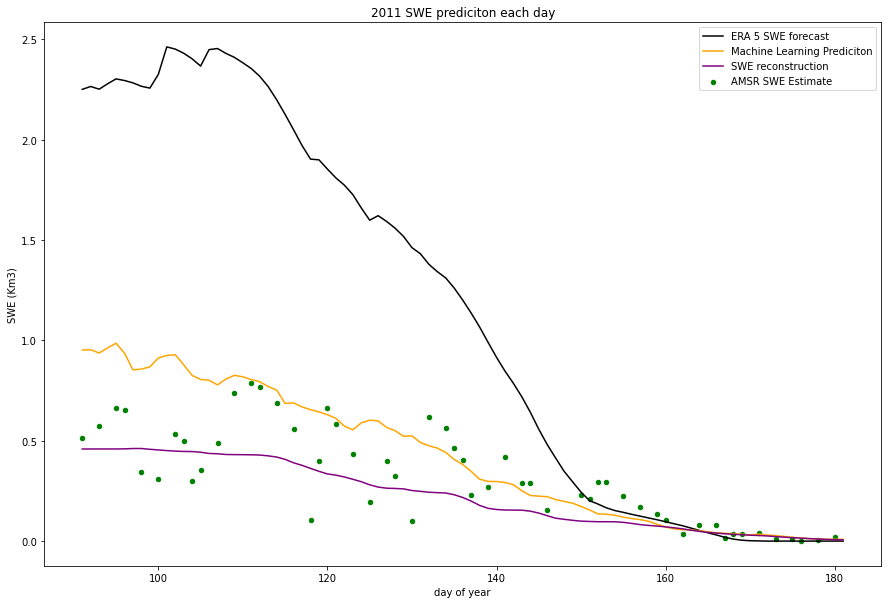

In [26]:
#define plot space
fig, ax = plt.subplots(figsize=(15,10))



#define x and y axis data - ERA 5 SWE forecast
opSWE.plot.scatter( x='doy',y='basinSWE_amsr',
                                        color='green', label= 'AMSR SWE Estimate', ax=ax)

#define x and y axis data - AMSR-Unified SWE estimate
opSWE.plot(kind='line',x='doy',y='basinSWE_era5',color='black', label= 'ERA 5 SWE forecast', ax=ax)


#define x and y axis data - Machine Learning Prediction
SWE.groupby('doy')['pxlVol'].sum().plot(kind='line',
                                        x='day of year',y='SWE (mm)',
                                        color='orange', label= 'Machine Learning Prediciton', ax=ax)

#define x and y axis data - Truth data from SWE reconstruciton
SWE.groupby('doy')['truthSWEpxlVol'].sum().plot(kind='line',
                                        x='day of year',y='SWE (mm)',
                                        color='purple', label = 'SWE reconstruction', ax=ax)

#set plot title and axes labels
ax.set(title=str(testYear)+' SWE prediciton each day',
       xlabel='day of year',
       ylabel='SWE (Km3)')

#plot all the data
plt.legend(loc='best')
plt.show()

## Fill gaps in AMSR SWE estimates

In [27]:
# remake the graph with a cubic spline interpolation of the point estimates from AMSR adn then use a rolling average

#calculate the cubic spline estimate of the AMSR data (same as lab 1)
amsrSWE_interp=pd.DataFrame(data={'doy':opSWE['doy'],'basinSWE_amsr': opSWE['basinSWE_amsr'].interpolate(method='cubicspline')})

# 7 day  moving average of the interpolated data
amsrSWE_avg=amsrSWE_interp.rolling(7).mean()


## Plot smoothed estimates of SWE from all methods in the labs

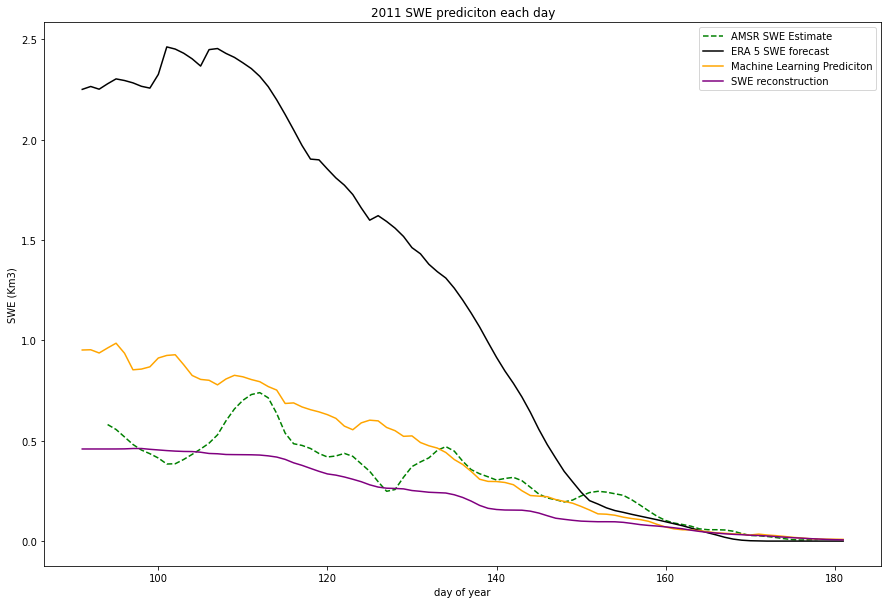

In [28]:
#define plot space
fig, ax = plt.subplots(figsize=(15,10))


#define x and y axis data - ERA 5 SWE forecast - POINTS
#opSWE.plot.scatter( x='doy',y='basinSWE_amsr',
#                                        color='green', label= 'AMSR SWE Estimate', ax=ax)

#define x and y axis data - ERA 5 SWE forecast - INTERPOLATION
#amsrSWE_interp.plot(kind='line', x='doy',y='basinSWE_amsr',
#                                        color='green', label= 'AMSR SWE Estimate', ax=ax)


#define x and y axis data - ERA 5 SWE forecast - rolling average
amsrSWE_avg.plot(kind='line', x='doy',y='basinSWE_amsr', style='--',
                                        color='green', label= 'AMSR SWE Estimate', ax=ax)


#define x and y axis data - AMSR-Unified SWE estimate
opSWE.plot(kind='line',x='doy',y='basinSWE_era5',color='black', label= 'ERA 5 SWE forecast', ax=ax)


#define x and y axis data - Machine Learning Prediction
SWE.groupby('doy')['pxlVol'].sum().plot(kind='line',
                                        x='day of year',y='SWE (mm)',
                                        color='orange', label= 'Machine Learning Prediciton', ax=ax)

#define x and y axis data - Truth data from SWE reconstruciton
SWE.groupby('doy')['truthSWEpxlVol'].sum().plot(kind='line',
                                        x='day of year',y='SWE (mm)',
                                        color='purple', label = 'SWE reconstruction', ax=ax)

#set plot title and axes labels
ax.set(title=str(testYear)+' SWE prediciton each day',
       xlabel='day of year',
       ylabel='SWE (Km3)')

#plot all the data
plt.legend(loc='best')
plt.show()

## Visualize feature importance from the ML model

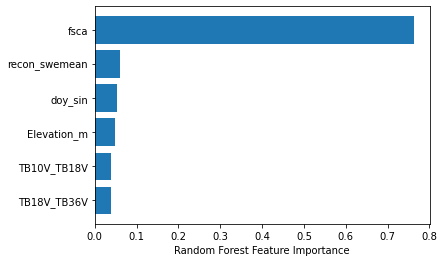

In [29]:
#calculate and plot feature importance
sorted_idx = SWEmodel.feature_importances_.argsort()
plt.barh(trainTbl.columns.values[sorted_idx], SWEmodel.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.show()

# PART 4: Try yourself - Train a model to predict SWE for another year

Now that we have predicted the data for 2011, lets say we wanted to see how the model would work for another year, how could we use our exiting data to train and test for another year besides the lteset year in the dataset (2011)?
reuse the code above to train and predict swe for any year from 2003 to 2010. Pick a partner and choose different years to train you model on then compare the output results to each others. We can then at the end go through and everyone can discuss how their model turend out for the year they trained it on. 
## Pick a new year to model and load the trained random forest model for that year

In [30]:
#load a model for a new year
newTestYear=2005
filename = str(newTestYear)+ '_RFmodel.joblib'

# load, no need to initialize the loaded_rf
SWEmodel = load(filename)

## Run Random Forest model and grab SWE estimates from other methods for the same year

In [31]:
#load year of data to predict swe for
sweTbl=pd.read_csv(str(newTestYear)+"Table.csv")
# delete pixels without fsca and outside of the basin
sweTbl = sweTbl[(sweTbl.fsca != 0) & (sweTbl.mask != 0)]
lat=sweTbl['Latitude']/100
lon=sweTbl['Longitude']/100

#testing data to validaitate the model
truthSWE=sweTbl.recon_swe

#predictors of SWE that go into the model - same as 2003-2010 data
doy=sweTbl.doy # we need this later
sweTbl = sweTbl[['doy_sin', 'Elevation_m', 'fsca','TB10V_TB18V','TB18V_TB36V','recon_swemean']].copy()
#lets run the trained ML model and try and predict SWE
predictSWE=SWEmodel.predict(sweTbl)
SWE=pd.DataFrame(data={'doy':doy,'lat':lat,'lon':lon,'SWE':predictSWE})
#swe volumne per pixel
SWE['pxlVol']=SWE['SWE']*1e-6*3.125*3.125
SWE['truthSWEpxlVol']=truthSWE*1e-6*3.125*3.125

#load the PM and AMSRSWE basin predicitons and plot as well.
file_name = '{}BasinSWE_km3_AMSR_ERA5.csv'
opSWE=pd.read_csv(file_name.format(newTestYear))
opSWE.loc[opSWE['basinSWE_amsr']==-99,'basinSWE_amsr']=np.nan

#calculate the cubic spline estimate of the AMSR data (same as lab 1)
amsrSWE_interp=pd.DataFrame(data={'doy':opSWE['doy'],'basinSWE_amsr': opSWE['basinSWE_amsr'].interpolate(method='cubicspline')})

# 7 day  moving average of the interpolated data
amsrSWE_avg=amsrSWE_interp.rolling(7).mean()

## Plot the results

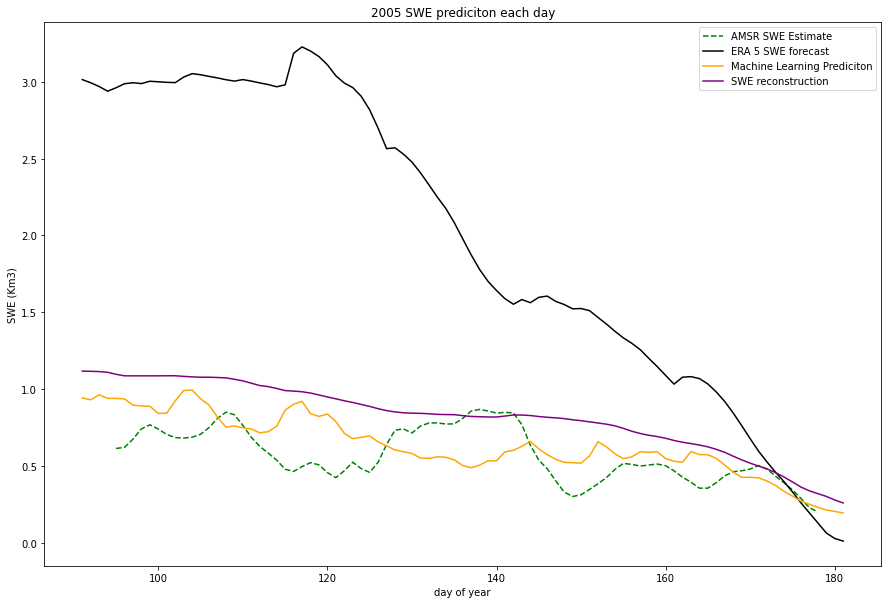

In [32]:
#define plot space
fig, ax = plt.subplots(figsize=(15,10))


#define x and y axis data - ERA 5 SWE forecast - POINTS
#opSWE.plot.scatter( x='doy',y='basinSWE_amsr',
#                                        color='green', label= 'AMSR SWE Estimate', ax=ax)

#define x and y axis data - ERA 5 SWE forecast - INTERPOLATION
#amsrSWE_interp.plot(kind='line', x='doy',y='basinSWE_amsr',
#                                        color='green', label= 'AMSR SWE Estimate', ax=ax)


#define x and y axis data - ERA 5 SWE forecast - rolling average
amsrSWE_avg.plot(kind='line', x='doy',y='basinSWE_amsr', style='--',
                                        color='green', label= 'AMSR SWE Estimate', ax=ax)


#define x and y axis data - AMSR-Unified SWE estimate
opSWE.plot(kind='line',x='doy',y='basinSWE_era5',color='black', label= 'ERA 5 SWE forecast', ax=ax)


#define x and y axis data - Machine Learning Prediction
SWE.groupby('doy')['pxlVol'].sum().plot(kind='line',
                                        x='day of year',y='SWE (mm)',
                                        color='orange', label= 'Machine Learning Prediciton', ax=ax)

#define x and y axis data - Truth data from SWE reconstruciton
SWE.groupby('doy')['truthSWEpxlVol'].sum().plot(kind='line',
                                        x='day of year',y='SWE (mm)',
                                        color='purple', label = 'SWE reconstruction', ax=ax)

#set plot title and axes labels
ax.set(title=str(newTestYear)+' SWE prediciton each day',
       xlabel='day of year',
       ylabel='SWE (Km3)')

#plot all the data
plt.legend(loc='best')
plt.show()